<a href="https://colab.research.google.com/github/g-kitiashvili/ML-Assignment4/blob/main/CNN_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 05: CNN with Data Augmentation
## Objective: Apply data augmentation techniques to improve model generalization and reduce overfitting

In [1]:
# Install necessary packages
!pip install wandb -q
!pip install kaggle -q
!pip install albumentations -q

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import wandb
from tqdm import tqdm
import os
import warnings
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive (optional - for saving results)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Setup kaggle directory
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download FER2013 dataset from Kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Extract the dataset
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!ls

 96% 275M/285M [00:04<00:00, 51.1MB/s]
100% 285M/285M [00:04<00:00, 73.0MB/s]
challenges-in-representation-learning-facial-expression-recognition-challenge.zip
drive
example_submission.csv
fer2013.tar.gz
icml_face_data.csv
sample_data
test.csv
train.csv


In [6]:
# Initialize W&B
wandb.login()
run = wandb.init(
    project="fer-challenge",
    name="exp05-cnn-data-augmentation",
    config={
        "architecture": "CNN with Data Augmentation",
        "dataset": "FER2013",
        "epochs": 30,
        "batch_size": 64,
        "learning_rate": 0.001,
        "weight_decay": 0.0001,
        "data_augmentation": True,
        "augmentation_techniques": ["rotation", "horizontal_flip", "brightness", "contrast", "gaussian_noise"],
        "conv_channels": [64, 128, 256, 256],
        "fc_sizes": [512, 256],
        "num_classes": 7
    }
)
# api key 380014f2a984b49876832184c6bd2dcddb337047


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qitiashvili13 (qitiashvili13-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
# Load and explore the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTraining data columns:", train_df.columns.tolist())
print("\nEmotion distribution:")
print(train_df['emotion'].value_counts().sort_index())

icml_df = pd.read_csv('icml_face_data.csv')

# Split ICML data based on 'Usage'
icml_train = icml_df[icml_df[' Usage'] == 'Training']
icml_test = icml_df[icml_df[' Usage'].isin(['PublicTest', 'Other'])]

# Drop the 'Usage' column (not needed after splitting)
icml_train = icml_train.drop(columns=[' Usage'])
icml_test = icml_test.drop(columns=[' Usage'])

# Merge datasets
train_df = pd.concat([train_df, icml_train], ignore_index=True)
test_df = pd.concat([test_df, icml_test], ignore_index=True)

# **Added data type check and filtering**
print("\nChecking 'pixels' column data types...")
initial_train_rows = len(train_df)
initial_test_rows = len(test_df)

train_df = train_df[train_df['pixels'].apply(lambda x: isinstance(x, str))]
test_df = test_df[test_df['pixels'].apply(lambda x: isinstance(x, str))]

print(f"Removed {initial_train_rows - len(train_df)} rows from training set due to non-string 'pixels'.")
print(f"Removed {initial_test_rows - len(test_df)} rows from test set due to non-string 'pixels'.")

# Shuffle the merged datasets (optional but recommended)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Output shapes and emotion distribution
print("\nMerged Train shape (after filtering):", train_df.shape)
print("Merged Test shape (after filtering):", test_df.shape)

print("\nEmotion distribution in merged train set:")
print(train_df['emotion'].value_counts().sort_index())

print("\nEmotion distribution in merged test set:")
print(test_df['emotion'].value_counts().sort_index())

Training data shape: (28709, 2)
Test data shape: (7178, 1)

Training data columns: ['emotion', 'pixels']

Emotion distribution:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Checking 'pixels' column data types...
Removed 28709 rows from training set due to non-string 'pixels'.
Removed 3589 rows from test set due to non-string 'pixels'.

Merged Train shape (after filtering): (28709, 3)
Merged Test shape (after filtering): (7178, 3)

Emotion distribution in merged train set:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Emotion distribution in merged test set:
Series([], Name: count, dtype: int64)


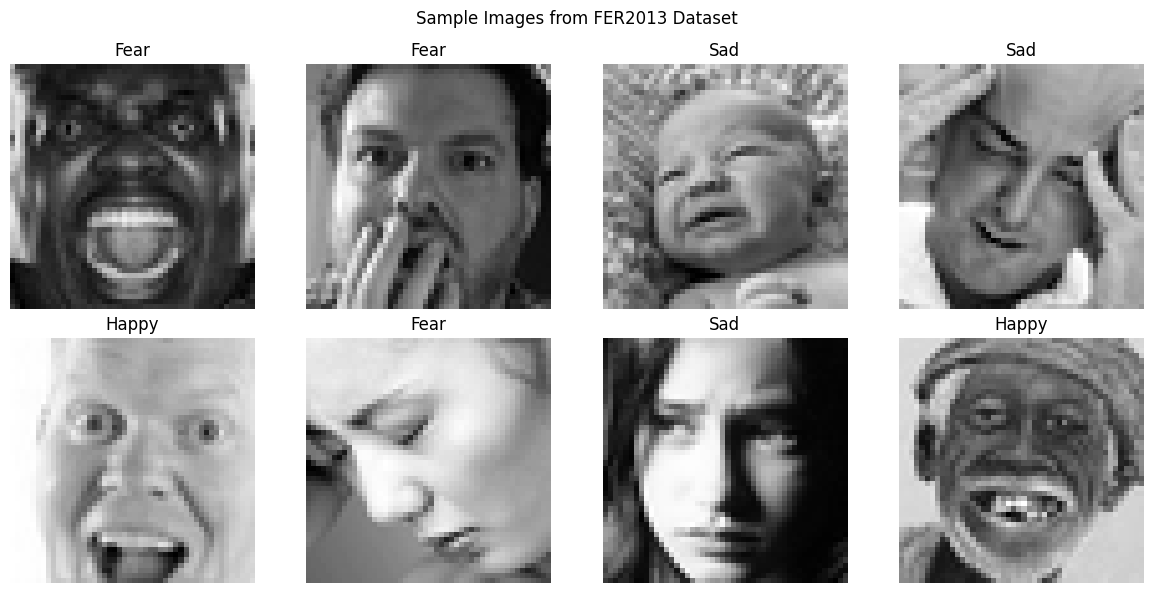

In [8]:
# Visualize sample images
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    idx = np.random.randint(0, len(train_df))
    pixels = train_df.iloc[idx]['pixels']
    emotion = train_df.iloc[idx]['emotion']

    # Convert pixel string to array and reshape
    pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.uint8)
    pixels = pixels.reshape(48, 48)

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'{emotion_labels[emotion]}')
    axes[i].axis('off')

plt.suptitle('Sample Images from FER2013 Dataset')
plt.tight_layout()
wandb.log({"sample_images": wandb.Image(plt)})
plt.show()

In [9]:
# Define data augmentation transforms
class AugmentedFERDataset(Dataset):
    def __init__(self, dataframe, is_training=True):
        self.data = dataframe
        self.is_training = is_training

        # Define augmentation pipeline for training
        if is_training:
            self.transform = A.Compose([
                A.Rotate(limit=15, p=0.5),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.3),
                A.Normalize(mean=[0.0], std=[1.0]),
                ToTensorV2()
            ])
        else:
            # No augmentation for validation/test
            self.transform = A.Compose([
                A.Normalize(mean=[0.0], std=[1.0]),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        # Convert pixel string to numpy array
        pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.uint8)
        pixels = pixels.reshape(48, 48)

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=pixels)
            pixels = augmented['image']

        # Ensure tensor is float and has correct shape (1, 48, 48)
        if len(pixels.shape) == 2:
            pixels = pixels.unsqueeze(0)

        return pixels.float(), torch.tensor(emotion, dtype=torch.long)

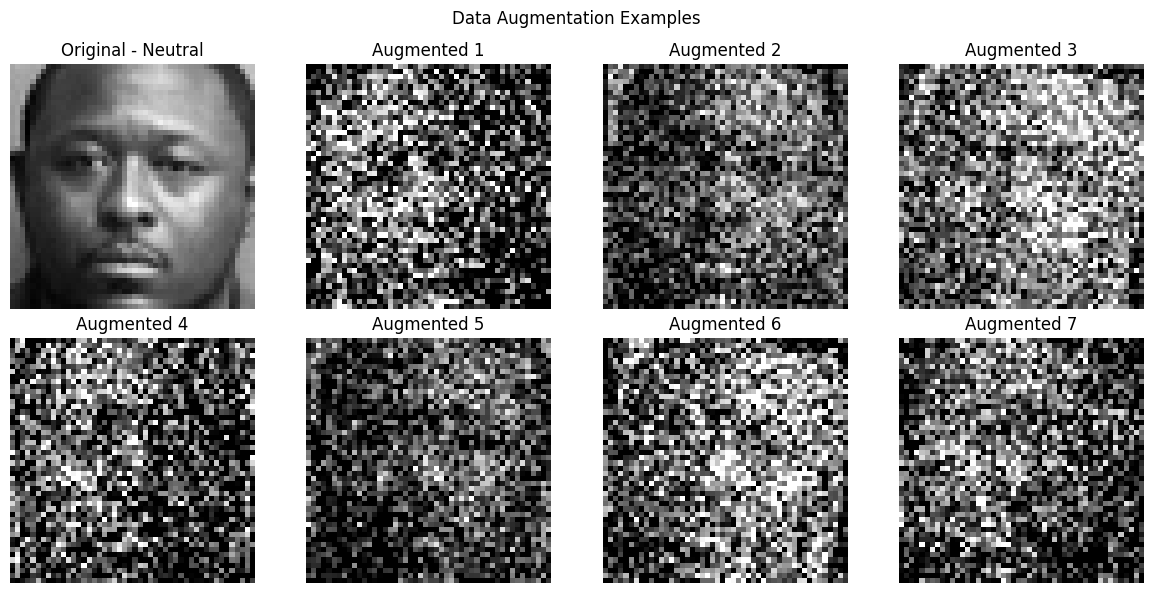

In [10]:
# Visualize augmented samples
sample_idx = 0
pixels = train_df.iloc[sample_idx]['pixels']
emotion = train_df.iloc[sample_idx]['emotion']

# Original image
pixels_orig = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.uint8)
pixels_orig = pixels_orig.reshape(48, 48)

# Create augmentation pipeline
aug_transform = A.Compose([
    A.Rotate(limit=15, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
    A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
])

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

# Show original
axes[0].imshow(pixels_orig, cmap='gray')
axes[0].set_title(f'Original - {emotion_labels[emotion]}')
axes[0].axis('off')

# Show 7 augmented versions
for i in range(1, 8):
    augmented = aug_transform(image=pixels_orig)
    axes[i].imshow(augmented['image'], cmap='gray')
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.suptitle('Data Augmentation Examples')
plt.tight_layout()
wandb.log({"augmentation_examples": wandb.Image(plt)})
plt.show()

In [11]:
# Create datasets with augmentation
full_dataset_train = AugmentedFERDataset(train_df, is_training=True)

# Split into train and validation
train_size = int(0.8 * len(full_dataset_train))
val_size = len(full_dataset_train) - train_size

# Create indices for splitting
indices = list(range(len(full_dataset_train)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[:train_size], indices[train_size:]

# Create train subset with augmentation
train_subset_df = train_df.iloc[train_indices].reset_index(drop=True)
val_subset_df = train_df.iloc[val_indices].reset_index(drop=True)

train_dataset = AugmentedFERDataset(train_subset_df, is_training=True)
val_dataset = AugmentedFERDataset(val_subset_df, is_training=False)  # No augmentation for validation

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

Train size: 22967
Validation size: 5742


In [12]:
# CNN Model (same architecture as previous experiments for fair comparison)
class AugmentedCNN(nn.Module):
    def __init__(self, num_classes=7, dropout_conv=0.2, dropout_fc=0.5):
        super(AugmentedCNN, self).__init__()

        # Conv Block 1
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(dropout_conv)

        # Conv Block 2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(dropout_conv)

        # Conv Block 3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(dropout_conv)

        # Conv Block 4
        self.conv4_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout2d(dropout_conv)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(dropout_fc)

        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(dropout_fc)

        self.fc3 = nn.Linear(256, num_classes)

        # Activation
        self.relu = nn.ReLU(inplace=True)

        # Calculate total parameters
        self.total_params = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        # Conv Block 1
        x = self.relu(self.bn1_1(self.conv1_1(x)))
        x = self.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Conv Block 2
        x = self.relu(self.bn2_1(self.conv2_1(x)))
        x = self.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Conv Block 3
        x = self.relu(self.bn3_1(self.conv3_1(x)))
        x = self.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Conv Block 4
        x = self.relu(self.bn4_1(self.conv4_1(x)))
        x = self.relu(self.bn4_2(self.conv4_2(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC layers
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)

        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc2(x)

        x = self.fc3(x)

        return x

In [13]:
# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = AugmentedCNN().to(device)
print(f"Total parameters: {model.total_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Log model architecture to W&B
wandb.watch(model, log='all')

Using device: cuda
Total parameters: 3,642,055


In [14]:
# Print model architecture
print("Model Architecture:")
print("=" * 50)
for name, param in model.named_parameters():
    print(f"{name:20} {param.shape}")
print("=" * 50)

Model Architecture:
conv1_1.weight       torch.Size([64, 1, 3, 3])
conv1_1.bias         torch.Size([64])
bn1_1.weight         torch.Size([64])
bn1_1.bias           torch.Size([64])
conv1_2.weight       torch.Size([64, 64, 3, 3])
conv1_2.bias         torch.Size([64])
bn1_2.weight         torch.Size([64])
bn1_2.bias           torch.Size([64])
conv2_1.weight       torch.Size([128, 64, 3, 3])
conv2_1.bias         torch.Size([128])
bn2_1.weight         torch.Size([128])
bn2_1.bias           torch.Size([128])
conv2_2.weight       torch.Size([128, 128, 3, 3])
conv2_2.bias         torch.Size([128])
bn2_2.weight         torch.Size([128])
bn2_2.bias           torch.Size([128])
conv3_1.weight       torch.Size([256, 128, 3, 3])
conv3_1.bias         torch.Size([256])
bn3_1.weight         torch.Size([256])
bn3_1.bias           torch.Size([256])
conv3_2.weight       torch.Size([256, 256, 3, 3])
conv3_2.bias         torch.Size([256])
bn3_2.weight         torch.Size([256])
bn3_2.bias           torch.Si

In [15]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc='Training')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100 * correct / total
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [16]:
# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(loader, desc='Validation')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': 100 * correct / total
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, all_predictions, all_labels

In [17]:
# Training loop
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0

for epoch in range(30):
    print(f'\nEpoch {epoch+1}/30')
    print('-' * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc, predictions, labels = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Log to W&B
    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'learning_rate': optimizer.param_groups[0]['lr'],
        'overfitting_gap': train_acc - val_acc
    })

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Overfitting Gap: {train_acc - val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_augmented_cnn_model.pth')
        print(f'New best model saved with validation accuracy: {val_acc:.2f}%')


Epoch 1/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.11it/s, loss=1.79, acc=25.6]


Train Loss: 1.8532, Train Acc: 22.89%
Val Loss: 1.7838, Val Acc: 25.57%
Overfitting Gap: -2.67%
New best model saved with validation accuracy: 25.57%

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 19.75it/s, loss=1.68, acc=28.9]


Train Loss: 1.8045, Train Acc: 24.66%
Val Loss: 1.7189, Val Acc: 28.86%
Overfitting Gap: -4.20%
New best model saved with validation accuracy: 28.86%

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:07<00:00, 11.97it/s, loss=1.48, acc=37.5]


Train Loss: 1.7337, Train Acc: 29.87%
Val Loss: 1.5899, Val Acc: 37.51%
Overfitting Gap: -7.64%
New best model saved with validation accuracy: 37.51%

Epoch 4/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.08it/s, loss=1.46, acc=41.3]


Train Loss: 1.6362, Train Acc: 35.25%
Val Loss: 1.4834, Val Acc: 41.34%
Overfitting Gap: -6.09%
New best model saved with validation accuracy: 41.34%

Epoch 5/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.50it/s, loss=1.34, acc=45.2]


Train Loss: 1.5704, Train Acc: 38.46%
Val Loss: 1.4165, Val Acc: 45.23%
Overfitting Gap: -6.76%
New best model saved with validation accuracy: 45.23%

Epoch 6/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.66it/s, loss=1.24, acc=47]


Train Loss: 1.5135, Train Acc: 40.65%
Val Loss: 1.3562, Val Acc: 46.95%
Overfitting Gap: -6.31%
New best model saved with validation accuracy: 46.95%

Epoch 7/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.80it/s, loss=1.22, acc=48.8]


Train Loss: 1.4715, Train Acc: 42.69%
Val Loss: 1.3149, Val Acc: 48.80%
Overfitting Gap: -6.11%
New best model saved with validation accuracy: 48.80%

Epoch 8/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.84it/s, loss=1.18, acc=51.3]


Train Loss: 1.4415, Train Acc: 44.03%
Val Loss: 1.2570, Val Acc: 51.31%
Overfitting Gap: -7.27%
New best model saved with validation accuracy: 51.31%

Epoch 9/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.50it/s, loss=1.21, acc=51.8]


Train Loss: 1.4164, Train Acc: 45.16%
Val Loss: 1.2468, Val Acc: 51.85%
Overfitting Gap: -6.68%
New best model saved with validation accuracy: 51.85%

Epoch 10/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.90it/s, loss=1.22, acc=53.3]


Train Loss: 1.3887, Train Acc: 46.14%
Val Loss: 1.2223, Val Acc: 53.31%
Overfitting Gap: -7.16%
New best model saved with validation accuracy: 53.31%

Epoch 11/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.86it/s, loss=1.21, acc=54.9]


Train Loss: 1.3715, Train Acc: 47.11%
Val Loss: 1.1980, Val Acc: 54.93%
Overfitting Gap: -7.82%
New best model saved with validation accuracy: 54.93%

Epoch 12/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.33it/s, loss=1.1, acc=54.6]


Train Loss: 1.3503, Train Acc: 48.11%
Val Loss: 1.1757, Val Acc: 54.58%
Overfitting Gap: -6.47%

Epoch 13/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 17.72it/s, loss=1.15, acc=54.4]


Train Loss: 1.3323, Train Acc: 48.49%
Val Loss: 1.1794, Val Acc: 54.37%
Overfitting Gap: -5.88%

Epoch 14/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 15.15it/s, loss=1.22, acc=54.9]


Train Loss: 1.3244, Train Acc: 49.10%
Val Loss: 1.1845, Val Acc: 54.91%
Overfitting Gap: -5.81%

Epoch 15/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 14.65it/s, loss=1.19, acc=56.6]


Train Loss: 1.3106, Train Acc: 49.55%
Val Loss: 1.1498, Val Acc: 56.60%
Overfitting Gap: -7.05%
New best model saved with validation accuracy: 56.60%

Epoch 16/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 17.75it/s, loss=1.14, acc=56.3]


Train Loss: 1.3019, Train Acc: 50.21%
Val Loss: 1.1343, Val Acc: 56.27%
Overfitting Gap: -6.06%

Epoch 17/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 19.23it/s, loss=1.18, acc=57.2]


Train Loss: 1.2969, Train Acc: 50.49%
Val Loss: 1.1152, Val Acc: 57.21%
Overfitting Gap: -6.72%
New best model saved with validation accuracy: 57.21%

Epoch 18/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.44it/s, loss=1.16, acc=58.1]


Train Loss: 1.2886, Train Acc: 50.58%
Val Loss: 1.1078, Val Acc: 58.06%
Overfitting Gap: -7.48%
New best model saved with validation accuracy: 58.06%

Epoch 19/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.92it/s, loss=1.1, acc=57.9]


Train Loss: 1.2809, Train Acc: 50.98%
Val Loss: 1.1006, Val Acc: 57.92%
Overfitting Gap: -6.94%

Epoch 20/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.68it/s, loss=1.11, acc=58.7]


Train Loss: 1.2702, Train Acc: 51.21%
Val Loss: 1.0827, Val Acc: 58.73%
Overfitting Gap: -7.51%
New best model saved with validation accuracy: 58.73%

Epoch 21/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.57it/s, loss=1.12, acc=59.2]


Train Loss: 1.2651, Train Acc: 51.73%
Val Loss: 1.0794, Val Acc: 59.21%
Overfitting Gap: -7.48%
New best model saved with validation accuracy: 59.21%

Epoch 22/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 20.80it/s, loss=1.09, acc=58.5]


Train Loss: 1.2572, Train Acc: 52.27%
Val Loss: 1.0829, Val Acc: 58.52%
Overfitting Gap: -6.25%

Epoch 23/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 19.76it/s, loss=1.15, acc=58.6]


Train Loss: 1.2481, Train Acc: 52.44%
Val Loss: 1.0781, Val Acc: 58.57%
Overfitting Gap: -6.13%

Epoch 24/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.80it/s, loss=1.11, acc=60.4]


Train Loss: 1.2435, Train Acc: 52.58%
Val Loss: 1.0511, Val Acc: 60.45%
Overfitting Gap: -7.87%
New best model saved with validation accuracy: 60.45%

Epoch 25/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.68it/s, loss=1.11, acc=59.7]


Train Loss: 1.2391, Train Acc: 52.79%
Val Loss: 1.0540, Val Acc: 59.68%
Overfitting Gap: -6.89%

Epoch 26/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.09it/s, loss=1.03, acc=59.6]


Train Loss: 1.2327, Train Acc: 53.27%
Val Loss: 1.0626, Val Acc: 59.65%
Overfitting Gap: -6.38%

Epoch 27/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.77it/s, loss=1.05, acc=59.8]


Train Loss: 1.2304, Train Acc: 52.88%
Val Loss: 1.0597, Val Acc: 59.80%
Overfitting Gap: -6.92%

Epoch 28/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 20.35it/s, loss=1.09, acc=59.2]


Train Loss: 1.2241, Train Acc: 53.49%
Val Loss: 1.0685, Val Acc: 59.23%
Overfitting Gap: -5.74%

Epoch 29/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:06<00:00, 14.55it/s, loss=1.24, acc=59.1]


Train Loss: 1.2196, Train Acc: 53.62%
Val Loss: 1.0716, Val Acc: 59.13%
Overfitting Gap: -5.50%

Epoch 30/30
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 15.01it/s, loss=1.05, acc=60]

Train Loss: 1.2222, Train Acc: 53.64%
Val Loss: 1.0435, Val Acc: 60.00%
Overfitting Gap: -6.35%


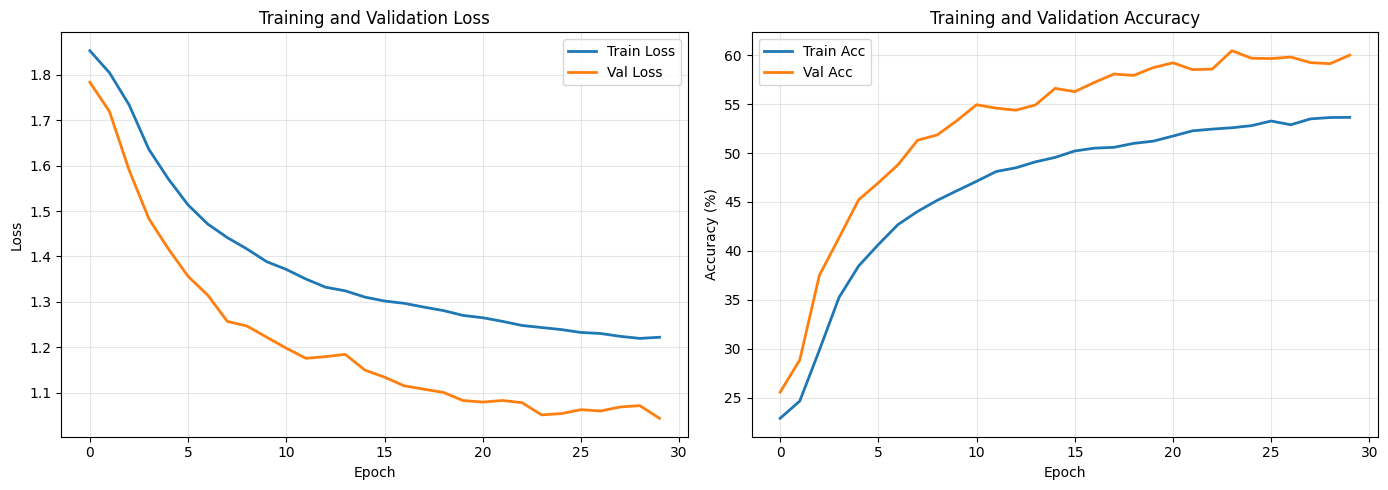

In [18]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', linewidth=2)
ax2.plot(val_accs, label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
wandb.log({"training_history": wandb.Image(plt)})
plt.show()

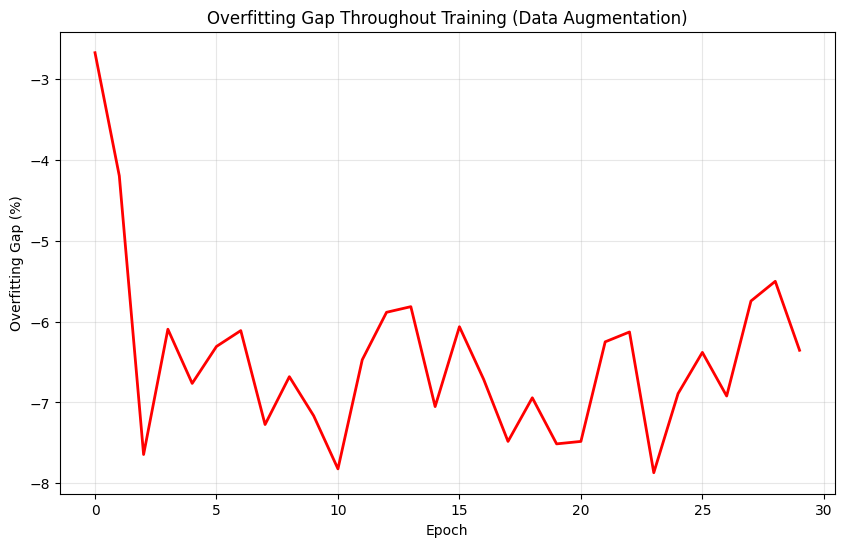

In [19]:
# Plot overfitting gap over time
plt.figure(figsize=(10, 6))
overfitting_gaps = [train_accs[i] - val_accs[i] for i in range(len(train_accs))]
plt.plot(overfitting_gaps, 'r-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Overfitting Gap (%)')
plt.title('Overfitting Gap Throughout Training (Data Augmentation)')
plt.grid(True, alpha=0.3)
wandb.log({"overfitting_gap_plot": wandb.Image(plt)})
plt.show()

Validation: 100%|██████████| 90/90 [00:04<00:00, 21.42it/s, loss=1.11, acc=60.4]


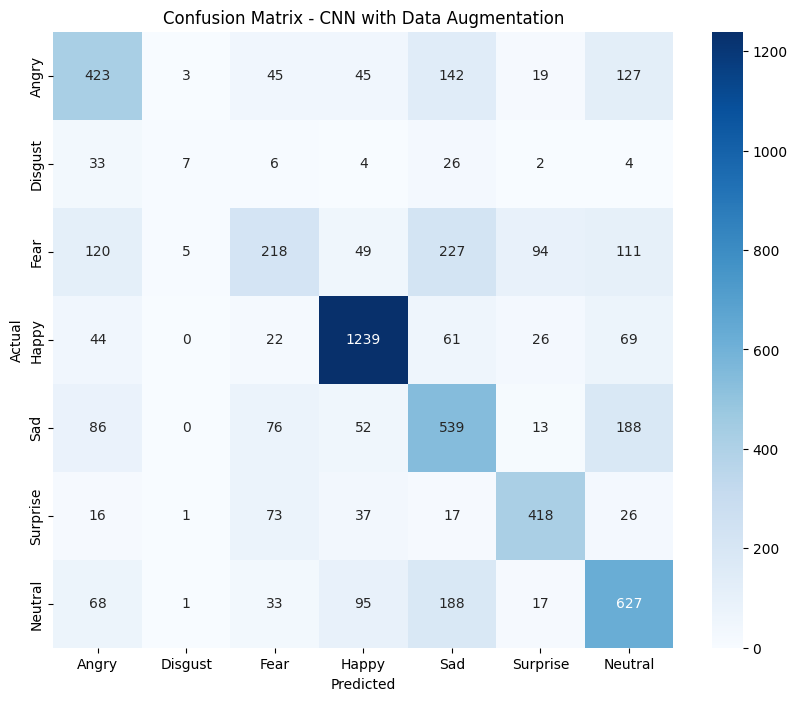

In [20]:
# Load best model for final evaluation
model.load_state_dict(torch.load('best_augmented_cnn_model.pth'))
_, _, final_predictions, final_labels = validate_epoch(model, val_loader, criterion, device)

# Confusion matrix
cm = confusion_matrix(final_labels, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN with Data Augmentation')
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

In [21]:
# Classification report
print("\nClassification Report:")
print("=" * 70)
report = classification_report(final_labels, final_predictions,
                             target_names=emotion_labels,
                             output_dict=True)
print(classification_report(final_labels, final_predictions, target_names=emotion_labels))

# Log per-class metrics to W&B
for emotion in emotion_labels:
    wandb.log({
        f"{emotion}_precision": report[emotion]['precision'],
        f"{emotion}_recall": report[emotion]['recall'],
        f"{emotion}_f1": report[emotion]['f1-score']
    })


Classification Report:
              precision    recall  f1-score   support

       Angry       0.54      0.53      0.53       804
     Disgust       0.41      0.09      0.14        82
        Fear       0.46      0.26      0.34       824
       Happy       0.81      0.85      0.83      1461
         Sad       0.45      0.56      0.50       954
    Surprise       0.71      0.71      0.71       588
     Neutral       0.54      0.61      0.57      1029

    accuracy                           0.60      5742
   macro avg       0.56      0.52      0.52      5742
weighted avg       0.60      0.60      0.59      5742



In [22]:
# Analyze misclassifications
misclassified_indices = np.where(np.array(final_predictions) != np.array(final_labels))[0]
correct_indices = np.where(np.array(final_predictions) == np.array(final_labels))[0]

print(f"\nTotal misclassifications: {len(misclassified_indices)} out of {len(final_labels)}")
print(f"Misclassification rate: {len(misclassified_indices)/len(final_labels)*100:.2f}%")


Total misclassifications: 2271 out of 5742
Misclassification rate: 39.55%


In [23]:
# Save final model and log to W&B
torch.save(model.state_dict(), 'final_augmented_cnn_model.pth')
wandb.save('final_augmented_cnn_model.pth')
wandb.save('best_augmented_cnn_model.pth')

# Summary statistics
summary_stats = {
    "final_train_accuracy": train_accs[-1],
    "final_val_accuracy": val_accs[-1],
    "best_val_accuracy": best_val_acc,
    "overfitting_gap": train_accs[-1] - val_accs[-1],
    "max_overfitting_gap": max(overfitting_gaps),
    "total_parameters": model.total_params,
    "macro_f1_score": report['macro avg']['f1-score'],
    "weighted_f1_score": report['weighted avg']['f1-score']
}

wandb.log(summary_stats)

In [24]:
# Final summary
print("\n" + "=" * 70)
print("EXPERIMENT SUMMARY: CNN WITH DATA AUGMENTATION")
print("=" * 70)
print(f"\nModel Architecture:")
print(f"  - 4 Convolutional Blocks (VGG-style)")
print(f"  - Conv channels: [64, 128, 256, 256]")
print(f"  - FC layers: [512, 256, 7]")
print(f"  - Total Parameters: {model.total_params:,}")
print(f"  - Data Augmentation: Rotation, Flip, Brightness/Contrast, Noise")

print(f"\nPerformance Metrics:")
print(f"  - Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"  - Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"  - Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  - Final Overfitting Gap: {train_accs[-1] - val_accs[-1]:.2f}%")
print(f"  - Maximum Overfitting Gap: {max(overfitting_gaps):.2f}%")
print(f"  - Macro F1-Score: {report['macro avg']['f1-score']:.3f}")

wandb.finish()


EXPERIMENT SUMMARY: CNN WITH DATA AUGMENTATION

Model Architecture:
  - 4 Convolutional Blocks (VGG-style)
  - Conv channels: [64, 128, 256, 256]
  - FC layers: [512, 256, 7]
  - Total Parameters: 3,642,055
  - Data Augmentation: Rotation, Flip, Brightness/Contrast, Noise

Performance Metrics:
  - Final Training Accuracy: 53.64%
  - Final Validation Accuracy: 60.00%
  - Best Validation Accuracy: 60.45%
  - Final Overfitting Gap: -6.35%
  - Maximum Overfitting Gap: -2.67%
  - Macro F1-Score: 0.518


Angry_f1,▁
Angry_precision,▁
Angry_recall,▁
Disgust_f1,▁
Disgust_precision,▁
Disgust_recall,▁
Fear_f1,▁
Fear_precision,▁
Fear_recall,▁
Happy_f1,▁
Happy_precision,▁
